In [1]:
import os
import random

from collections import defaultdict

import gym
import numpy as np
import matplotlib.pyplot as plt

from gym import spaces
from scipy.spatial.distance import cdist
from scipy.special import softmax
from tqdm.auto import tqdm

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed = 3000
seed_everything(seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def generate_maze(width, height):
    """Generates a simple maze.

    Args:
        width: The width of the maze.
        height: The height of the maze.

    Returns:
        A numpy array representing the maze, where 0 is empty space and 1 is a wall.
    """
    maze = np.zeros((height, width), dtype=int)
    maze[1::2, 1::2] = 1
    return maze

def generate_goal_pairs(maze, num_of_goal_pairs, temp=1.):
    """Generates pairs of goal positions within a maze.

    Args:
        maze: A numpy array representing the maze.
        num_of_goal_pairs: The number of goal pairs to generate.
        temp: Temperature parameter for the softmax distribution.

    Returns:
        A numpy array of shape (num_of_goal_pairs, 2, 2) containing pairs of goal coordinates.
        Each goal pair is represented as ((row1, col1), (row2, col2)).
    """
    empty_spaces = maze == 0
    indices = np.argwhere(empty_spaces)
    n = len(indices)

    dists = cdist(indices, indices)
    np.fill_diagonal(dists, -np.inf)
    p = softmax(dists.flatten() / temp)
    pairs = np.random.choice(range(n**2), size=num_of_goal_pairs, p=p)
    src_idx, dest_idx = np.divmod(pairs, n)
    src, dest = indices[src_idx], indices[dest_idx]
    goal_pairs = np.stack([src, dest], axis=1)
    return goal_pairs

height, width = 16, 16
maze = generate_maze(width, height)
print("Maze:")
print(maze)

num_of_goal_pairs = 10
goal_pairs = generate_goal_pairs(maze, num_of_goal_pairs, temp=3)

num_of_charging_stations = 3

goals = goal_pairs.reshape(-1, 2)
goals = [tuple(goal) for goal in goals]

margin = 2

empty_spaces = []

for i in range(margin, height - margin):
    for j in range(margin, width - margin):
        if maze[i, j] == 0 and (i, j) not in goals:
            empty_spaces.append((i, j))

charging_stations = random.sample(empty_spaces, k=num_of_charging_stations)

print("Goal Pairs:")
print(goal_pairs)

print("Charging Stations:")
print(charging_stations)

Maze:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]]
Goal Pairs:
[[[ 8  2]
  [ 0 13]]

 [[10  1]
  [15 12]]

 [[12 10]
  [ 6  7]]

 [[ 3 12]
  [ 8 12]]

 [[ 8  6]
  [ 0  4]]

 [[12 15]
  [ 4  1]]

 [[14  5]
  [ 2 10]]

 [[ 1  0]
  [10  6]]

 [[ 8 12]
  [13  2]]

 [[ 8 11]
  [ 1  6]]]
Charging Stations:
[(11, 12), (4, 2), (6, 8)]


In [4]:
class MazeEnv(gym.Env):
    def __init__(self, maze, goal_pairs, charging_stations):
        super(MazeEnv, self).__init__()
        self.maze = maze
        self.height, self.width = maze.shape
        self.action_space = spaces.Discrete(4)  # 4 possible actions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.height, self.width), dtype=np.uint8)
        self.start_pos = (0, 0)
        self.goal_pos = goal_pairs.reshape(-1, 2)
        self.goal_idx = 0
        self.agent_pos = self.start_pos
        self.energy = 100
        self.charging_stations = charging_stations
        self.reset()

    def reset(self):
        self.agent_pos = self.start_pos
        self.goal_idx = 0
        self.energy = 100
        return self._get_obs()

    def _get_obs(self):
        maze = np.copy(self.maze)
        maze[self.agent_pos] = 2  # Mark agent's position
        goal_idx = self.goal_idx
        energy = self.energy
        return (maze, goal_idx, energy)

    def step(self, action):
        new_pos = list(self.agent_pos)
        if action == 0:  # up
            new_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == 1:  # down
            new_pos[0] = min(self.agent_pos[0] + 1, self.height - 1)
        elif action == 2:  # left
            new_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 3:  # right
            new_pos[1] = min(self.agent_pos[1] + 1, self.width - 1)

        self.energy -= 1

        reward = -0.1  # Small penalty for each step to encourage exploration

        if self.maze[tuple(new_pos)] == 1:  # Hit a wall
            new_pos = self.agent_pos

        self.agent_pos = tuple(new_pos)

        if self.agent_pos == tuple(self.goal_pos[self.goal_idx]):
            self.goal_idx = self.goal_idx + 1
            reward = 100  # Large reward for reaching the goal

        if self.agent_pos in self.charging_stations:
            if self.energy < 20:
                reward = 1 # Reward for get charged when battery is low
                self.energy = 100
            else:
                reward = -1 # Penalty for get charged when battery is high

        done = (self.goal_idx == len(self.goal_pos)) or (self.energy == 0)

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        maze, goal_idx, energy = self._get_obs()
        print("Maze:")
        print(maze)
        if goal_idx < len(self.goal_pos):
            print(f"Energy [{energy}/100], Goal [{goal_idx}/{len(self.goal_pos)}]: ", self.goal_pos[goal_idx])
        else:
            print("Done!")

env = MazeEnv(maze, goal_pairs, charging_stations)

env.seed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

env.render()

Maze:
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]]
Energy [100/100], Goal [0/20]:  [8 2]


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [5]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.05):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return self.env.action_space.sample()
        else:
            maze, goal_idx, energy = state
            state = (tuple(maze.flatten()), goal_idx, energy > 20)
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        maze, goal_idx, energy = state
        state = (tuple(maze.flatten()), goal_idx, energy > 20)

        maze, goal_idx, energy = next_state
        next_state = (tuple(maze.flatten()), goal_idx, energy > 20)

        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_delta

    def train(self, episodes=1000):
        r = []
        steps = []
        pbar = tqdm(range(episodes), desc="Episode")

        for episode in pbar:
            state = self.env.reset()
            done = False
            total_reward = 0
            num_steps = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.learn(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                num_steps += 1

            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            log = {
                "Explorate rate": self.exploration_rate,
                "Total reward": total_reward,
                "Number of steps": num_steps,
            }
            pbar.set_postfix(log)

            r.append(total_reward)
            steps.append(num_steps)

        return r, steps

agent = QLearningAgent(env, exploration_decay=0.9995)
r, steps = agent.train(10_000)

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
# Test the trained agent
agent.exploration_rate = 0.0
state = agent.env.reset()
done = False
num_steps = 0
total_reward = 0
charging_station_visited = 0
energies = []

while not done:
    action = agent.choose_action(state)
    state, reward, done, _ = agent.env.step(action)

    if agent.env.energy == 100:
        charging_station_visited += 1

    energies.append(agent.env.energy)

    agent.env.render()
    num_steps += 1
    total_reward += reward

print("Total steps:", num_steps)
print("Total reward:", total_reward)
print("Number of charging: ", charging_station_visited)

Streaming output truncated to the last 5000 lines.
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]]
Energy [90/100], Goal [1/20]:  [ 0 13]
Maze:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 

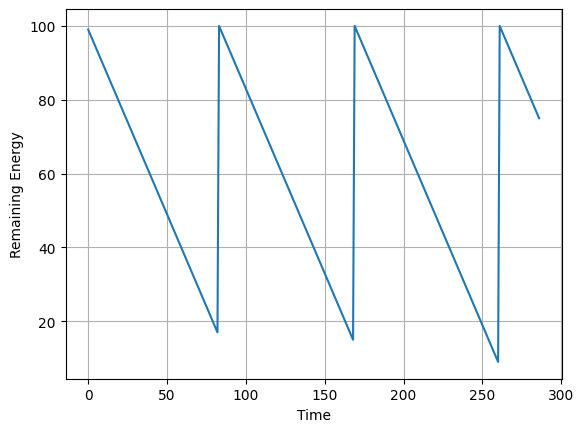

In [7]:
plt.plot(energies)
plt.xlabel("Time")
plt.ylabel("Remaining Energy")
plt.grid()
plt.show()